In [1]:
import numpy as np
import pandas as pd
import thesis.jaxdaw as jd
import matplotlib.pyplot as plt
import jax.numpy as jnp

from jax import random, vmap
from thesis.glitch import GlitchModel, GlitchPrior, estimate_asy


In [2]:
names = ["worst", "better", "best"]

obs = {}
v19 = {}
gp = {}
for name in names:
    obs[name] = pd.read_csv(f"data/glitch-inputs-{name}.csv")
    v19[name] = pd.read_csv(f"data/v19-glitch-results-{name}.csv", index_col=0)
    gp[name] = jd.load_results(f"data/gp-glitch-results-{name}.h5")

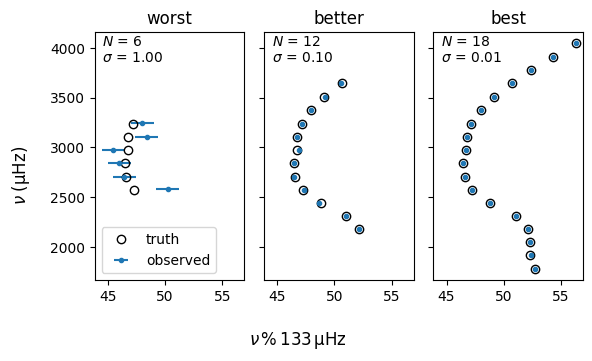

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(6, 3.6), sharey=True, sharex=True, 
                        #  gridspec_kw={"wspace": 0.0}
                        )
delta_nu = 133.0

for i, (k, v) in enumerate(obs.items()):
    ax = axes[i]
    ax.errorbar(v.nu%delta_nu, v.nu, xerr=v.nu_err, fmt=".", label="observed")
    err = v.nu_err.iloc[0]
    ax.text(0.05, 0.88, f"$N$ = {len(v)}\n$\\sigma$ = {err:.2f}", 
            transform=ax.transAxes)
    
    ax.plot(v.nu_true%delta_nu, v.nu_true, "ok", markerfacecolor="none", label="truth")
    ax.set_title(k)

axes[0].legend(loc="lower left")

fig.supxlabel(f"$\\nu\\,\\% \\,{delta_nu:.0f}\\,\\mathrm{{\\mu Hz}}$")
fig.supylabel(r"$\nu\;(\mathrm{\mu Hz})$")
fig.tight_layout()

In [4]:
rng = random.PRNGKey(2023)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
shape = (1000,)

gps = {}
for k, v in gp.items():
    rng, key = random.split(rng)
    gps[k] = jd.resample(key, v, shape=shape)

In [6]:
model = {}
for k, v in obs.items():
    n, nu, nu_err = v.n.to_numpy(), v.nu.to_numpy(), v.nu_err.to_numpy()
    args = estimate_asy(n, nu, nu_err)
    prior = GlitchPrior(*args)
    model[k] = GlitchModel(prior, n=n, nu=nu, nu_err=nu_err)

In [7]:
def _oscillation(nu, tau, phi):
    return np.sin(4 * np.pi * tau * nu + phi)

def poly(p, x):
    powers = np.arange(p.shape[-1])
    return np.sum(p*x[..., None]**powers, axis=-1)

def smooth_component(param, n, npoly_params=5):
    return np.apply_along_axis(
        poly, 
        -1,
        param[..., :npoly_params], 
        n,
    )

def helium_amp(param, nu):
    return param[..., -4, None] * nu * np.exp(- 8e-12 * np.pi**2 * param[..., -3, None]**2 * nu**2)

def helium_glitch(param, nu):
    return helium_amp(param, nu) * _oscillation(nu, 1e-6*param[..., -2, None], param[..., -1, None])

def bcz_amp(param, nu):
    return param[..., -7, None] / nu**2

def bcz_glitch(param, nu):
    return bcz_amp(param, nu) * _oscillation(nu, 1e-6*param[..., -6, None], param[..., -5, None])

def glitch(param, nu):
    return helium_glitch(param, nu) + bcz_glitch(param, nu)

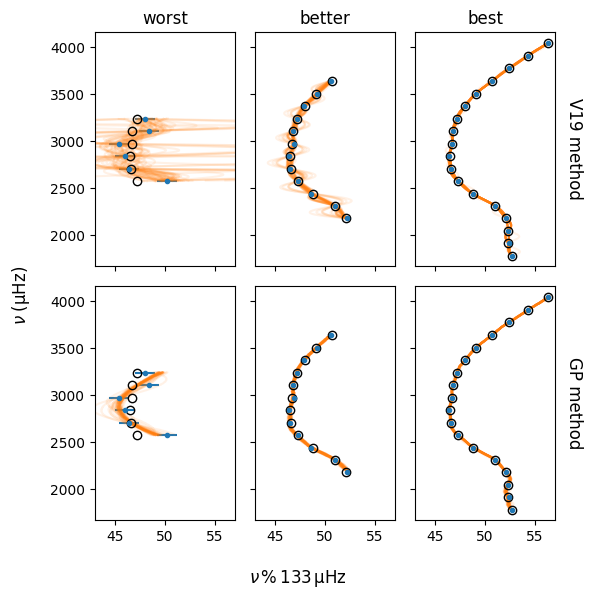

In [8]:
fig, (axtop, axbot) = plt.subplots(2, 3, figsize=(6, 6), sharey=True, sharex=True, 
                        #  gridspec_kw={"wspace": 0.05, "hspace": 0.05}
                         )
draws = 50

for i, (k, v) in enumerate(v19.items()):
    ax = axtop[i]
    ax.set_title(k)
    ax.errorbar(obs[k].nu%delta_nu, obs[k].nu, xerr=obs[k].nu_err, fmt=".", label="observed")

    thin = len(v) // draws
    n_pred = np.linspace(obs[k].n.min(), obs[k].n.max(), 201)
    param = v.iloc[:, :-2].to_numpy()

    nu_pred = smooth_component(param, n_pred)
    nu_pred += glitch(param, nu_pred)
    x = (nu_pred - n_pred * delta_nu) % delta_nu
    ax.plot(x[::thin].T, nu_pred[::thin].T, color="C1", alpha=0.1)
    
    ax.plot(obs[k].nu_true%delta_nu, obs[k].nu_true, "ok",
            markerfacecolor="none", label="truth")

ax.yaxis.set_label_position("right")
ax.set_ylabel("V19 method", rotation=270, labelpad=20., fontsize="large")

for i, (k, v) in enumerate(model.items()):
    ax = axbot[i]
    rng, key = random.split(rng)
    v.plot_echelle(key, gps[k], delta_nu=delta_nu, draws=draws, color="C1", alpha=0.1, ax=ax)
    ax.plot(obs[k].nu_true%delta_nu, obs[k].nu_true, "ok", 
            markerfacecolor="none", label="truth")
    
ax.set_xlim(43, 57)
ax.yaxis.set_label_position("right")
ax.set_ylabel("GP method", rotation=270, labelpad=20., fontsize="large")

fig.supxlabel(f"$\\nu\\,\\% \\,{delta_nu:.0f}\\,\\mathrm{{\\mu Hz}}$")
fig.supylabel(r"$\nu\;(\mathrm{\mu Hz})$")
fig.tight_layout()

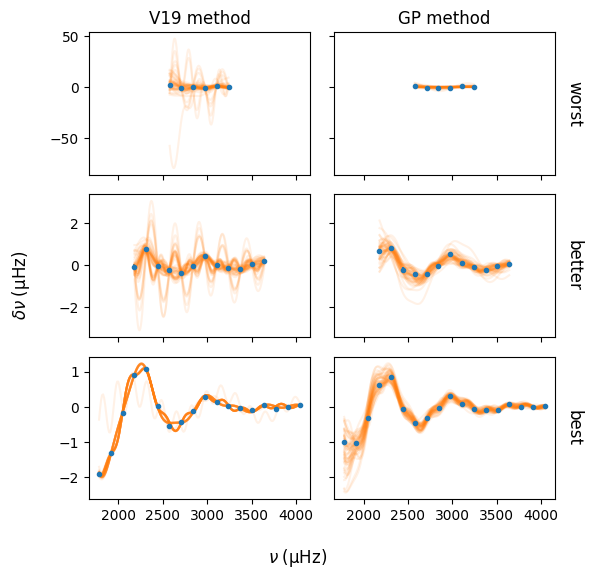

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(6, 5.8), sharey="row", sharex=True, 
                        #  gridspec_kw={"wspace": 0.05, "hspace": 0.05}
                         )
(axtop, axbot) = axes.T

for i, (k, v) in enumerate(v19.items()):
    ax = axtop[i]
    if i == 0:
        ax.set_title("V19 method")
    thin = len(v) // draws
    nu_pred = np.linspace(obs[k].nu.min(), obs[k].nu.max(), 201)
    param = v.iloc[:, :-2].to_numpy()

    nu_sm = np.median(smooth_component(param, obs[k].n.to_numpy()), axis=0)
    dnu = obs[k].nu.to_numpy() - nu_sm
    ax.errorbar(nu_sm, dnu, yerr=obs[k].nu_err, fmt=".")
    
    dnu_pred = glitch(param, nu_pred)
    x = np.broadcast_to(nu_pred, dnu_pred.shape)
    ax.plot(x[::thin].T, dnu_pred[::thin].T, color="C1", alpha=0.1)

for i, (k, v) in enumerate(model.items()):
    ax = axbot[i]
    if i == 0:
        ax.set_title("GP method")
    v.plot_glitch(gps[k], draws=draws, color="C1", alpha=0.1, ax=ax)

    nu_gp, _ = vmap(lambda x: v.predict(x, v.n, include_mean=False))(gps[k])
    nu_sm = vmap(lambda x: v.smooth_component(x, v.n))(gps[k])
    dnu = v.nu - nu_sm - nu_gp
    ax.errorbar(np.median(nu_sm, axis=0), np.median(dnu, axis=0), yerr=v.nu_err, fmt=".")
    
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(k, rotation=270, labelpad=20., fontsize="large")

fig.supxlabel(r"$\nu\;(\mathrm{\mu Hz})$")
fig.supylabel(r"$\delta\nu\;(\mathrm{\mu Hz})$")

# ax.set_ylim(-3, 3)
fig.tight_layout()


In [10]:
from corner import corner

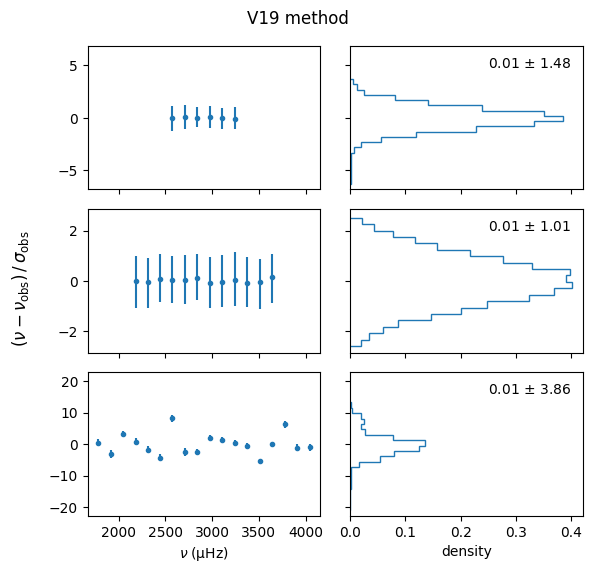

In [75]:
fig, axes = plt.subplots(3, 2, figsize=(6, 5.8), sharey="row", sharex="col",
                        #  gridspec_kw={"wspace": 0.05, "hspace": 0.05}
                         )
(axtop, axbot) = axes.T

for i, (k, v) in enumerate(v19.items()):
    ax = axtop[i]

    param = v.iloc[:, :-2].to_numpy()
    nu = smooth_component(param, obs[k].n.to_numpy())
    nu += glitch(param, nu)
    
    nu_true = obs[k].nu_true.to_numpy()
    nu_err = obs[k].nu_err.to_numpy()
    nu_obs = obs[k].nu.to_numpy()

    res = (nu - nu_obs) / nu_err
    # res = (nu - nu_true) / nu_err
    res_med = np.median(res, 0)
    res_low, res_upp = np.quantile(res, [.16, .84], 0)
    # plt.plot(nu, res, ".C1", alpha=0.1)
    ax.errorbar(nu_true, res_med, yerr=[res_med-res_low, res_upp-res_med], fmt=".")
    # break
    rmin, rmax = np.quantile(res, [.01, .99], 0)
    ax = axbot[i]
    ax.hist(res.ravel(), bins=20, range=(rmin.min(), rmax.max()), 
            histtype="step", orientation="horizontal", density=True)
    
    ylim = np.abs(ax.get_ylim()).max()
    ax.set_ylim(-ylim, ylim)
    ax.text(0.95, 0.85, f"{res.mean():.2f} $\\pm$ {res.std():.2f}", 
            transform=ax.transAxes, horizontalalignment="right")

axtop[i].set_xlabel(r"$\nu \; (\mathrm{\mu Hz})$")
axbot[i].set_xlabel("density")

fig.suptitle("V19 method")
fig.supylabel(r"$(\nu - \nu_\mathrm{obs}) \, / \, \sigma_\mathrm{obs}$")
fig.tight_layout()
    
    

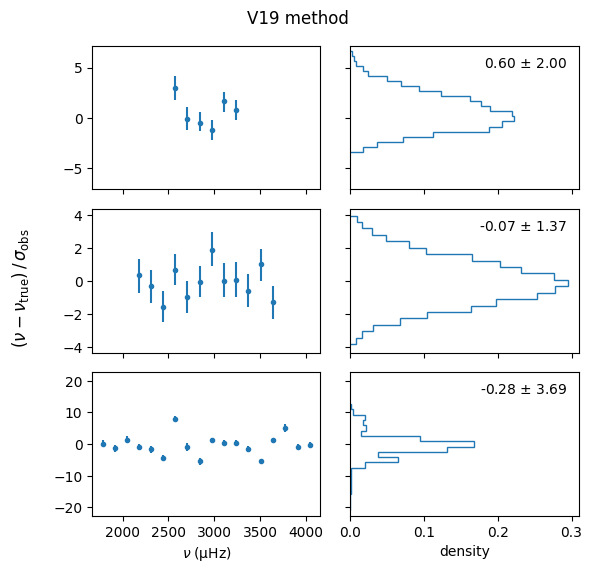

In [78]:
fig, axes = plt.subplots(3, 2, figsize=(6, 5.8), sharey="row", sharex="col",
                        #  gridspec_kw={"wspace": 0.05, "hspace": 0.05}
                         )
(axtop, axbot) = axes.T

for i, (k, v) in enumerate(v19.items()):
    ax = axtop[i]

    param = v.iloc[:, :-2].to_numpy()
    nu = smooth_component(param, obs[k].n.to_numpy())
    nu += glitch(param, nu)
    
    nu_true = obs[k].nu_true.to_numpy()
    nu_err = obs[k].nu_err.to_numpy()
    nu_obs = obs[k].nu.to_numpy()

    res = (nu - nu_true) / nu_err
    # res = (nu - nu_true) / nu_err
    res_med = np.median(res, 0)
    res_low, res_upp = np.quantile(res, [.16, .84], 0)
    # plt.plot(nu, res, ".C1", alpha=0.1)
    ax.errorbar(nu_true, res_med, yerr=[res_med-res_low, res_upp-res_med], fmt=".")
    # break
    rmin, rmax = np.quantile(res, [.01, .99], 0)
    ax = axbot[i]
    ax.hist(res.ravel(), bins=20, range=(rmin.min(), rmax.max()), 
            histtype="step", orientation="horizontal", density=True)
    
    ylim = np.abs(ax.get_ylim()).max()
    ax.set_ylim(-ylim, ylim)
    ax.text(0.95, 0.85, f"{res.mean():.2f} $\\pm$ {res.std():.2f}", 
            transform=ax.transAxes, horizontalalignment="right")

axtop[i].set_xlabel(r"$\nu \; (\mathrm{\mu Hz})$")
axbot[i].set_xlabel("density")

fig.suptitle("V19 method")
fig.supylabel(r"$(\nu - \nu_\mathrm{true}) \, / \, \sigma_\mathrm{obs}$")
fig.tight_layout()


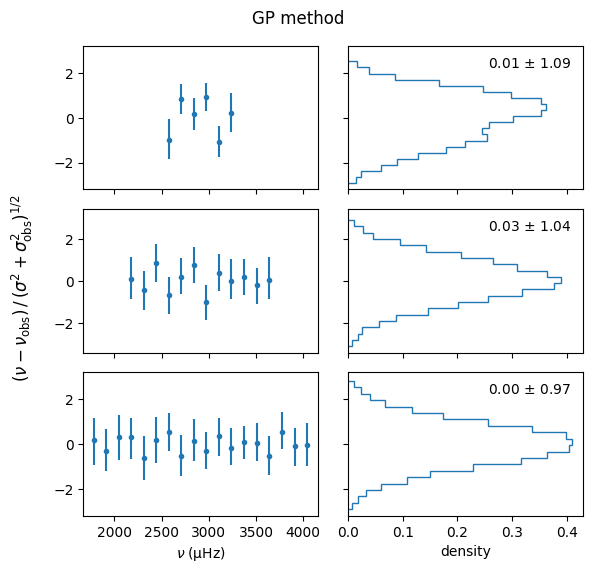

In [76]:
fig, axes = plt.subplots(3, 2, figsize=(6, 5.8), sharey="row", sharex="col",
                        #  gridspec_kw={"wspace": 0.05, "hspace": 0.05}
                         )
(axtop, axbot) = axes.T

for i, (k, v) in enumerate(model.items()):
    ax = axtop[i]
    
    # nu, nu_var = vmap(lambda x: v.predict(x, v.n))(gps[k])
    keys = random.split(rng, gps[k]["delta_nu"].shape[0])
    nu = vmap(lambda k, x: v.sample(k, x, v.n))(keys, gps[k])
    # Not a great idea to just use nu_var as points are correlated
    nu_true = obs[k].nu_true.to_numpy()
    nu_err = obs[k].nu_err.to_numpy()
    nu_obs = obs[k].nu.to_numpy()

    sig2 = np.exp(2*gps[k]["log_sigma"])
    res = (nu - nu_obs) / np.sqrt(sig2[:, None] + nu_err**2)
    # res = (nu - nu_obs) / np.sqrt(nu_var + nu_err**2)
    # res = (nu - nu_true) / np.sqrt(nu_var + nu_err**2)
    res_med = np.median(res, 0)
    res_low, res_upp = np.quantile(res, [.16, .84], 0)
    
    # ax.errorbar(nu_true, nu_obs - nu_true, yerr=nu_err, fmt=".")
    ax.errorbar(nu_true, res_med, yerr=[res_med-res_low, res_upp-res_med], fmt=".")
    
    rmin, rmax = np.quantile(res, [.01, .99], 0)
    ax = axbot[i]
    ax.hist(res.ravel(), bins=20, range=(rmin.min(), rmax.max()),
            histtype="step", orientation="horizontal", density=True)
    
    ylim = np.abs(ax.get_ylim()).max()
    ax.set_ylim(-ylim, ylim)
    ax.text(0.95, 0.85, f"{res.mean():.2f} $\\pm$ {res.std():.2f}", 
            transform=ax.transAxes, horizontalalignment="right")


axtop[i].set_xlabel(r"$\nu \; (\mathrm{\mu Hz})$")
axbot[i].set_xlabel("density")

fig.supylabel(r"$(\nu - \nu_\mathrm{obs}) \, / \, (\sigma^2 + \sigma_\mathrm{obs}^2)^{1/2}$")


fig.suptitle("GP method")
fig.tight_layout()

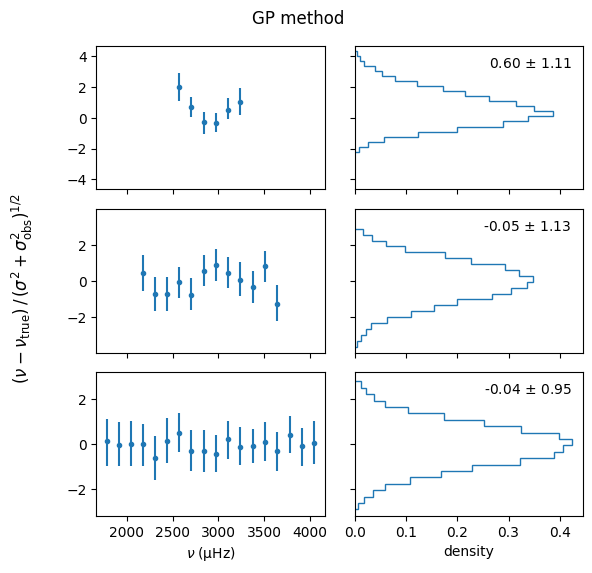

In [77]:
fig, axes = plt.subplots(3, 2, figsize=(6, 5.8), sharey="row", sharex="col",
                        #  gridspec_kw={"wspace": 0.05, "hspace": 0.05}
                         )
(axtop, axbot) = axes.T

for i, (k, v) in enumerate(model.items()):
    ax = axtop[i]
    
    # nu, nu_var = vmap(lambda x: v.predict(x, v.n))(gps[k])
    keys = random.split(rng, gps[k]["delta_nu"].shape[0])
    nu = vmap(lambda k, x: v.sample(k, x, v.n))(keys, gps[k])
    # Not a great idea to just use nu_var as points are correlated
    nu_true = obs[k].nu_true.to_numpy()
    nu_err = obs[k].nu_err.to_numpy()
    nu_obs = obs[k].nu.to_numpy()

    sig2 = np.exp(2*gps[k]["log_sigma"])
    res = (nu - nu_true) / np.sqrt(sig2[:, None] + nu_err**2)
    # res = (nu - nu_obs) / np.sqrt(nu_var + nu_err**2)
    # res = (nu - nu_true) / np.sqrt(nu_var + nu_err**2)
    res_med = np.median(res, 0)
    res_low, res_upp = np.quantile(res, [.16, .84], 0)
    
    # ax.errorbar(nu_true, nu_obs - nu_true, yerr=nu_err, fmt=".")
    ax.errorbar(nu_true, res_med, yerr=[res_med-res_low, res_upp-res_med], fmt=".")
    
    rmin, rmax = np.quantile(res, [.01, .99], 0)
    ax = axbot[i]
    ax.hist(res.ravel(), bins=20, range=(rmin.min(), rmax.max()),
            histtype="step", orientation="horizontal", density=True)
    
    ylim = np.abs(ax.get_ylim()).max()
    ax.set_ylim(-ylim, ylim)
    ax.text(0.95, 0.85, f"{res.mean():.2f} $\\pm$ {res.std():.2f}", 
            transform=ax.transAxes, horizontalalignment="right")


axtop[i].set_xlabel(r"$\nu \; (\mathrm{\mu Hz})$")
axbot[i].set_xlabel("density")

fig.supylabel(r"$(\nu - \nu_\mathrm{true}) \, / \, (\sigma^2 + \sigma_\mathrm{obs}^2)^{1/2}$")


fig.suptitle("GP method")
fig.tight_layout()

In [79]:
nu_ref = 3000.

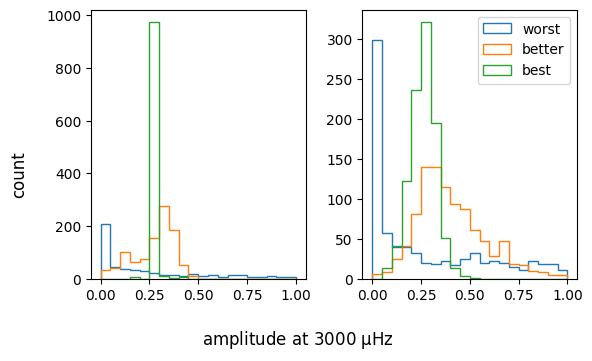

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3.6), sharex=True)

ax = axes[0]
for k, v in v19.items():
    param = v.iloc[:, :-2].to_numpy()
    ahe = helium_amp(param, nu_ref)
    ax.hist(ahe, range=(0, 1), bins=20, histtype="step")

ax = axes[1]
for k, v in gps.items():
    ahe = model[k].helium_amp(v, nu_ref)
    ax.hist(ahe, range=(0, 1), bins=20, histtype="step", label=k)

ax.legend()

fig.supxlabel(f"amplitude at {nu_ref:.0f} " + r"$\mathrm{\mu Hz}$")
fig.supylabel(f"count")

fig.tight_layout()

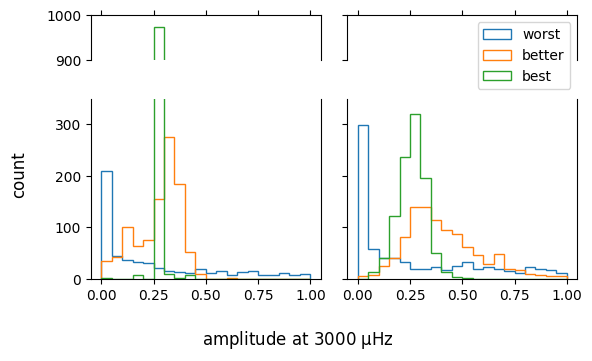

In [114]:
fig, (axtop, axbot) = plt.subplots(2, 2, figsize=(6, 3.6), sharex=True, sharey="row",
                                   gridspec_kw={"height_ratios": [1, 4]})

ax = axbot[0]
axt = axtop[0]
for k, v in v19.items():
    param = v.iloc[:, :-2].to_numpy()
    ahe = helium_amp(param, nu_ref)
    ax.hist(ahe, range=(0, 1), bins=20, histtype="step")
    axt.hist(ahe, range=(0, 1), bins=20, histtype="step")
    
    ax.spines['top'].set_visible(False)
    ax.xaxis.tick_bottom()
    axt.xaxis.tick_top()
    axt.tick_params(labeltop=False)
    axt.spines['bottom'].set_visible(False)

ax = axbot[1]
axt = axtop[1]
for k, v in gps.items():
    ahe = model[k].helium_amp(v, nu_ref)
    ax.hist(ahe, range=(0, 1), bins=20, histtype="step")
    axt.hist(ahe, range=(0, 1), bins=20, histtype="step", label=k)
    
    ax.spines['top'].set_visible(False)
    ax.xaxis.tick_bottom()
    axt.xaxis.tick_top()
    axt.tick_params(labeltop=False)
    axt.spines['bottom'].set_visible(False)

ax.set_ylim(0, 350)
axt.set_ylim(900, 1000)

axt.legend()

fig.supxlabel(f"amplitude at {nu_ref:.0f} " + r"$\mathrm{\mu Hz}$")
fig.supylabel(f"count")

fig.tight_layout()